In [ ]:
neck vessel

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import cv2
from glob import glob
# import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [5]:
import tensorflow as tf

In [ ]:
# tf.__version__

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4
IMG_PATH = "/content/drive/MyDrive/Colab Notebooks/processed_data/aug_img/"
MASK_PATH = "/content/drive/MyDrive/Colab Notebooks/processed_data/aug_mask/"

In [9]:
data = {'img': [], 'mask': []}

imgs = glob(IMG_PATH + '*')
masks = glob(MASK_PATH + '*')

# 코랩에서 중복 저장된 넘들 지우기
trash = glob('/content/drive/MyDrive/Colab Notebooks/processed_data/aug_mask/*(1)*')

for i in trash:
  masks.remove(i)

imgs.sort()
masks.sort()

for i in imgs:
    img = plt.imread(i)
    # img = plt.imread(i, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    data['img'].append(img)
    
for i in masks:
    try:
      mask = plt.imread(i)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # mask = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    except:
      mask = plt.imread(i)

    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    data['mask'].append(mask)

# print(data['img'][:10], "\n", data['mask'][:10])
print(len(data['img']), len(data['mask']))

415 415


In [15]:
np.unique(data['mask'][10])

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  13,  16,  17,
        18,  19,  20,  22,  23,  24,  25,  26,  31,  32,  35,  37,  38,
        44,  46,  47,  51,  52,  55,  59,  72,  75,  77,  81,  83,  85,
        95,  97,  98,  99, 100, 101, 103, 104, 119, 127, 129, 130, 151,
       154, 155, 162, 163, 165, 174, 178, 194, 195, 202, 205, 212, 214,
       215, 218, 220, 222, 228, 229, 231, 233, 237, 239, 240, 241, 242,
       243, 244, 245, 249, 250, 251, 252, 253, 254, 255], dtype=uint8)

In [13]:
for i in range(10):
  print(data['img'][i].shape)

(256, 256, 3)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256, 3)


In [22]:
imgs.sort()
masks.sort()

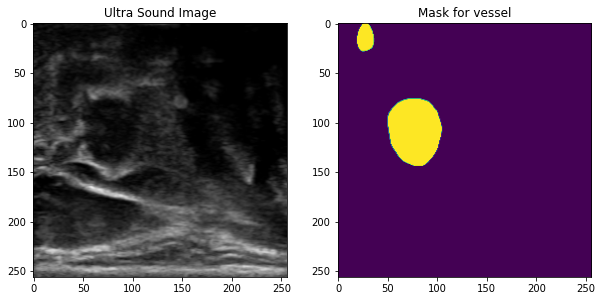

In [14]:
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(data['img'][400])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(data['mask'][400])
plt.title('Mask for vessel')
plt.show()

In [15]:
def split_data(images, masks, split=0.25):
    train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split, random_state=42)

    valid_x, test_x = train_test_split(valid_x, test_size = 0.5, random_state=42)
    valid_y, test_y = train_test_split(valid_y, test_size = 0.5, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [16]:
split = 0.2
train_x, valid_x = train_test_split(data['img'], test_size=split, random_state=42)
train_y, valid_y = train_test_split(data['mask'], test_size=split, random_state=42)

# valid_x, test_x = train_test_split(valid_x, test_size = 0.5, random_state=42)
# valid_y, test_y = train_test_split(valid_y, test_size = 0.5, random_state=42)

In [17]:
train_ = {'img': [], 'mask': []}
valid_ = {'img': [], 'mask': []}
for x in train_x:
    train_['img'].append(x)
for y in train_y:
    train_['mask'].append(y)
for x in valid_x:
    valid_['img'].append(x)
for y in valid_y:
    valid_['mask'].append(y)
print(len(train_['mask']))
print(len(valid_['mask']))

332
83


In [18]:
for img in valid_['mask']:
    print(img.shape)
    break

(256, 256)


In [ ]:
train_['img'][0].shape

(256, 256, 3)

In [19]:
for i in range(len(train_['img'])):
    try:
        reshaped_img = train_['img'][i].reshape(256, 256, 1)
        reshaped_img = cv2.cvtColor(reshaped_img, cv2.COLOR_GRAY2BGR)
        train_['img'][i] = reshaped_img      
    except:
        reshaped_img = train_['img'][i].reshape(256, 256, 3)
        train_['img'][i] = reshaped_img      

In [20]:
for i in range(len(valid_['img'])):
    try:
        reshaped_img = valid_['img'][i].reshape(256, 256, 1)
        reshaped_img = cv2.cvtColor(reshaped_img, cv2.COLOR_GRAY2BGR)
        valid_['img'][i] = reshaped_img      
    except:
        reshaped_img = valid_['img'][i].reshape(256, 256, 3)
        valid_['img'][i] = reshaped_img      

In [21]:
# for l in valid_['img']:
#     print(l.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 

In [ ]:
for i in range(50):
    if not valid_['mask'][i].shape == valid_['img'][i].shape:
        print(i)
        break

0


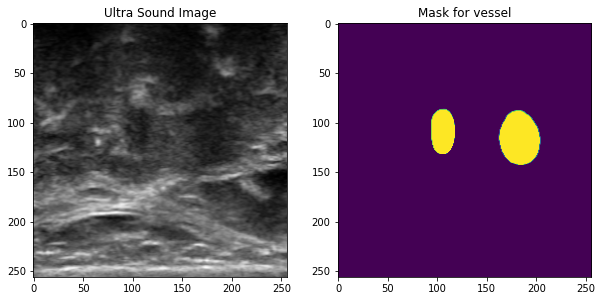

In [22]:
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(valid_['img'][12])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(valid_['mask'][12])
plt.title('Mask for vessel')
plt.show()

In [23]:
def unet_resnet():
    inputs = Input(shape=(256, 256, 3), name="input_image")
    
    encoder = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)
    skip_connection_names = ["input_image", "conv1_relu", "conv2_block3_out", "conv3_block4_out"]
    encoder_output = encoder.get_layer("conv4_block6_out").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        print(x_skip.shape)
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# smooth = 1e-15
# def dice_coef(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)

In [24]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('장치 수: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
장치 수: 1


In [52]:
with strategy.scope():

  inputs = tf.keras.layers.Input((256, 256, 3))
  model2 = Unet(inputs, droupouts= 0.07)

In [26]:
with strategy.scope():
    train_steps = len(train_x)//BATCH
    valid_steps = len(valid_x)//BATCH

    if len(train_x) % BATCH != 0:
        train_steps += 1
    if len(valid_x) % BATCH != 0:
        valid_steps += 1

In [27]:
with strategy.scope():
    model = unet_resnet()
    opt = tf.keras.optimizers.Nadam(LR)
    metrics = ['accuracy', Recall(), Precision()]
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    ]

    # mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='max', verbose=1, save_best_only=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [30]:
with strategy.scope():
    hist = model.fit(np.array(train_['img']), np.array(train_['mask']),
                      validation_data = (np.array(valid_['img']), np.array(valid_['mask'])),
                      epochs = EPOCHS,
                      steps_per_epoch=train_steps,
                      validation_steps=valid_steps,
                      callbacks=callbacks)

Epoch 1/30
42/42 [==============================] - 90s 709ms/step - loss: 0.5686 - accuracy: 0.7415 - recall: 0.5244 - precision: 0.1624 - val_loss: 6.1550 - val_accuracy: 0.0871 - val_recall: 0.9967 - val_precision: 0.0624
Epoch 2/30
42/42 [==============================] - 23s 543ms/step - loss: 0.2933 - accuracy: 0.9665 - recall: 0.6287 - precision: 0.8809 - val_loss: 1.1116 - val_accuracy: 0.1626 - val_recall: 0.9846 - val_precision: 0.0670
Epoch 3/30
42/42 [==============================] - 23s 539ms/step - loss: 0.2334 - accuracy: 0.9637 - recall: 0.5979 - precision: 0.9352 - val_loss: 0.7902 - val_accuracy: 0.5050 - val_recall: 0.1822 - val_precision: 0.0243
Epoch 4/30
42/42 [==============================] - 23s 541ms/step - loss: 0.2114 - accuracy: 0.9702 - recall: 0.6793 - precision: 0.9198 - val_loss: 0.4502 - val_accuracy: 0.8909 - val_recall: 0.0108 - val_precision: 0.0132
Epoch 5/30
42/42 [==============================] - 23s 540ms/step - loss: 0.1942 - accuracy: 0.9779

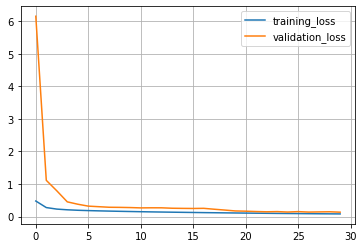

In [31]:
plt.plot(hist.history['loss'], label = 'training_loss')
plt.plot(hist.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.grid(True)

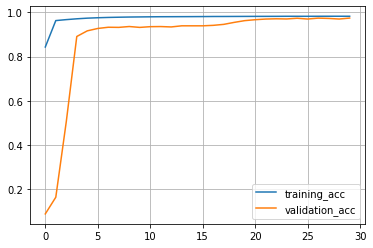

In [32]:
plt.plot(hist.history['accuracy'], label = 'training_acc')
plt.plot(hist.history['val_accuracy'], label = 'validation_acc')
plt.legend()
plt.grid(True)

In [70]:
# model.save('vessel_model.h5')

In [71]:
# !ls

drive  sample_data  vessel_model.h5


In [ ]:
# from tensorflow.keras.models import load_model
# model = unet_resnet()
# model = load_model('vessel_model.h5')

(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
(None, 256, 256, 3)


In [56]:
def prediction(test, model, shape = 256):
    ## getting and proccessing val data
    img = test['img'][0:16]
    mask = test['mask'][0:16]
    
    predictions = model.predict(np.array(img))

    return predictions, imgProc, mask

In [42]:
def Plotter(img, predMask, mask):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title('Actual mask')

In [65]:
pred, img, mask = prediction(valid_, model, shape = 256)

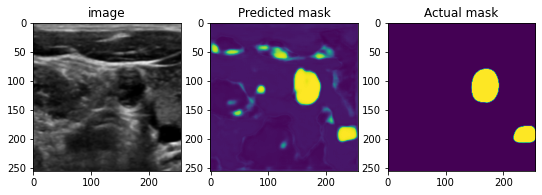

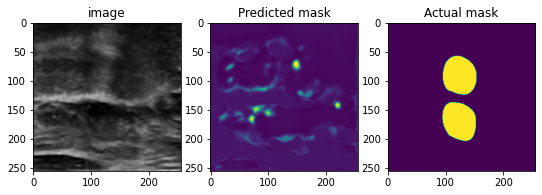

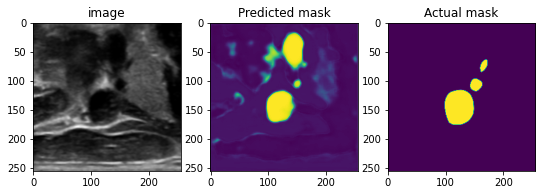

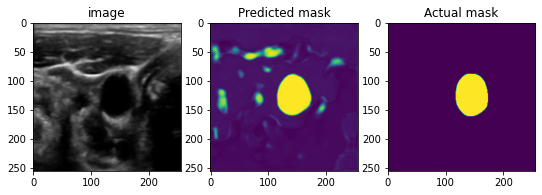

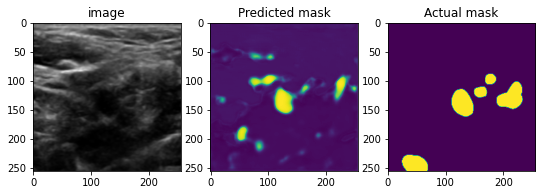

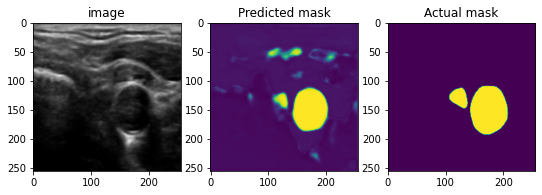

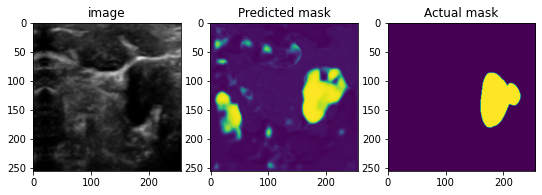

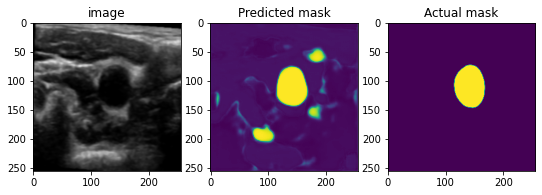

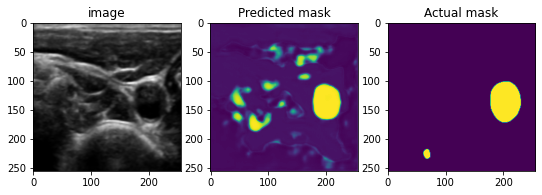

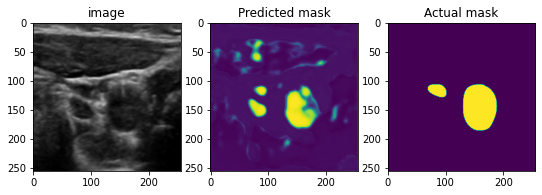

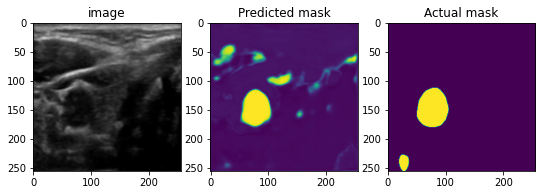

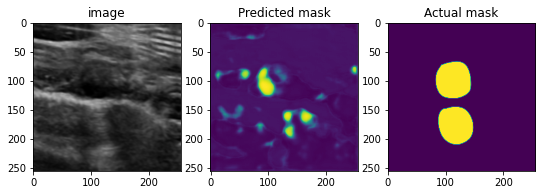

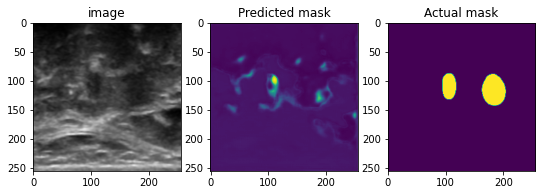

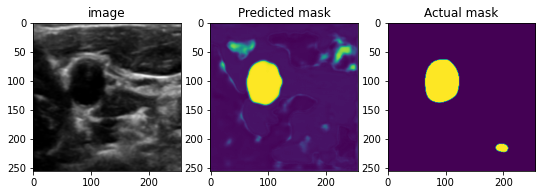

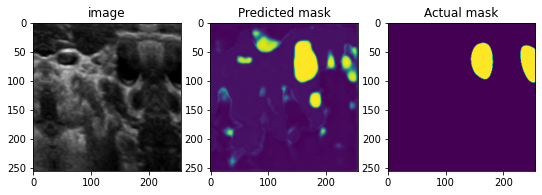

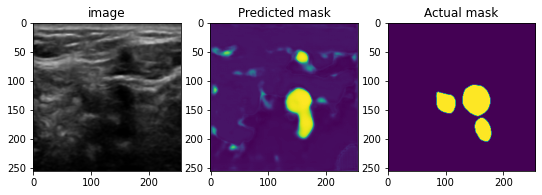

In [66]:
for i in range(16):
  Plotter(img[i], pred[i][:,:,0], mask[i])

In [ ]:
## threshold 조정하려고 했던 시절
ints = np.unique(predictions[0])
ints.sort()
print(ints)
thres = ints[int(-1 * len(ints) * 0.0001)]
print(thres)

[0.0619389  0.06334586 0.06345823 ... 0.19928731 0.19961645 0.20267332]
0.19261432


In [ ]:
super_threshold_indices = a > thres
a[super_threshold_indices] = 0


array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [ ]:
np.unique(predictions[0])

array([0.07996596, 0.08072703, 0.08112854, ..., 0.29368287, 0.29471552,
       0.30450264], dtype=float32)

In [ ]:
super_threshold_indices

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

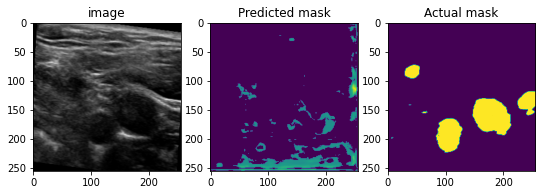

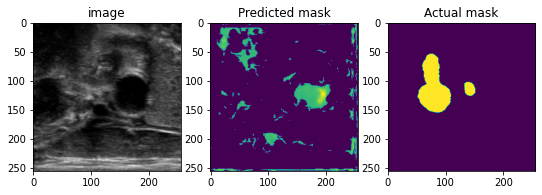

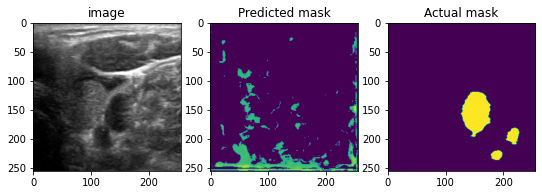

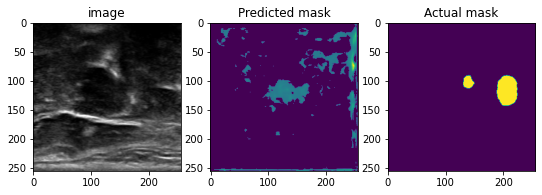

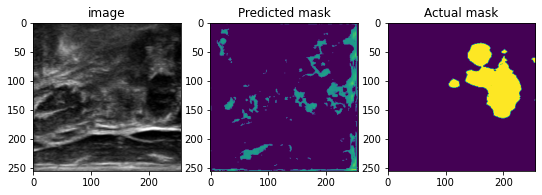

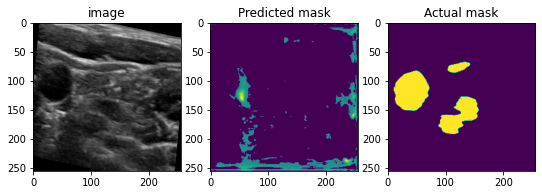

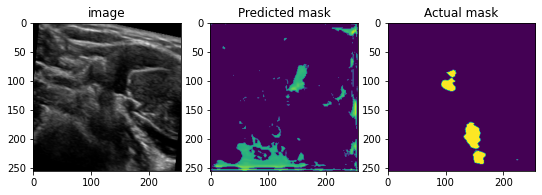

In [ ]:
for i in range(7):
    pred =  predictions[i]
    ints = np.unique(predictions[i])
    ints.sort()
    thres = ints[int(-1 * len(ints) * 0.1)]
#     thres = ints[-1]
    super_threshold_indices = pred < thres
    pred[super_threshold_indices] = 0
    Plotter(img[i], pred, mask[i])

In [ ]:
# 점수 내보던 시절
diff = predictions[1].flatten() - valid_['mask'][1].flatten()
a = (1 - diff) * 100
m = np.mean(a)
print(m)

96.084564


In [ ]:
print(a)

[89.99728  87.034355 88.97796  ... 83.59766  86.01133  87.03223 ]


In [ ]:
# 데이터 적으니 test는 사치다
# test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

# test_steps = (len(test_x)//BATCH)
# if len(test_x) % BATCH != 0:
#     test_steps += 1

# model.evaluate(test_dataset, steps=test_steps)